In [1]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
from skimage.io import imread
from iaf.plot import imshow
from iaf.notebook import init_style
from pathlib import Path
init_style()

# Statistical thresholding

This example shows how to use the characteristics of the signal (or rather, in this case, of the background) to segment objects that are otherwise tricky to segment with standard thresholding algorithms.

The data we have consists of an image `N` of already segmented (i.e. black and white) nuclei from a fluorescence microscopy acquisition, an image `S` of the corresponding cells with a (weak and noisy) fluorescent signal that (where present) fills the whole cell. 

Our goal is to quantify the fraction of positive cells in the image. The positive cells are those cells that have a cellular signal that is detectable above noise level. We can use the `N` image to know where all the cells are (because all nuclei are strongly labelled), and the `S` image to sample the signal at the position of the nuclei and decide whether it is significant or not.

## Read and display the images

We start by reading the images.

In [2]:
N = imread(Path(Path.home() / "openbis/raw_data/20240916113758953-89/original/notebooks_data/stats_nuclei_bw.tif"))
S = imread(Path(Path.home() / "openbis/raw_data/20240916113758953-89/original/notebooks_data/stats_signal.tif"))

`N` is the segmented image of the nuclei, that is, we are given a black-and-white mask. `S` is the background-corrected cellular signal image.

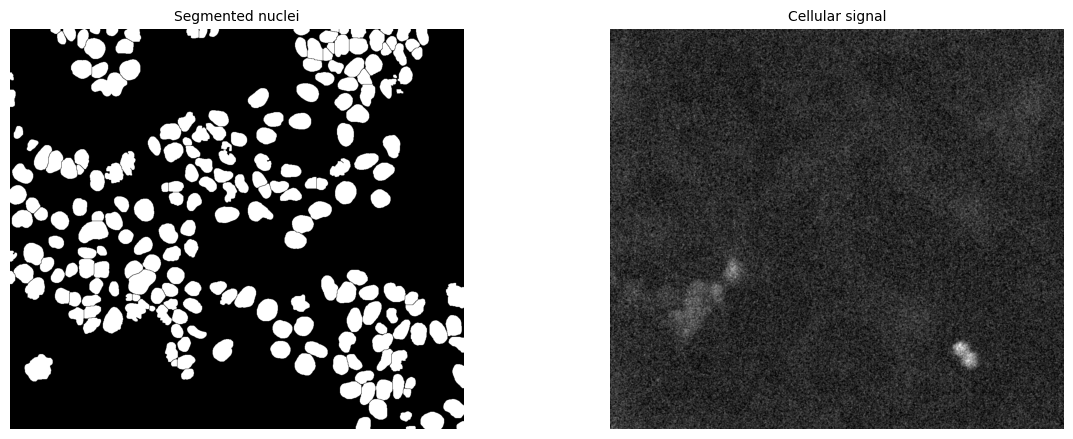

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
imshow(N, cmap="gray", ax=ax[0], title="Segmented nuclei")
imshow(S, cmap="gray", ax=ax[1], title="Cellular signal");

How do we know which cells in `S` have a significant signal? Let's start by naively segmenting `S` with Otsu.

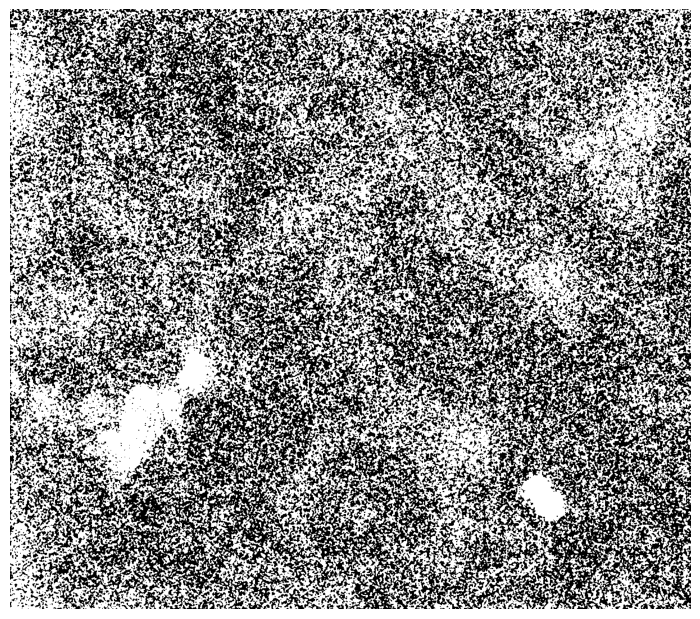

In [4]:
threshold = threshold_otsu(S)
bw_S = S > threshold
imshow(bw_S)

This does not look very good. Let's see if we can find a better approach.

## Two words about *sample distributions*

We will start by considering a sample $X$ of 10000 randomly sampled numbers from a Normal distribution $X \sim \mathcal{N}(\mu, \sigma^{2})$ with mean $\mu = 100$ and standard deviation $\sigma=5$, i.e. $X \sim \mathcal{N}(100\,25)\$.

Numpy's `random.randn()` function returns numbers sampled from a standard normal distribution with mean 0 and standard deviation 1.

In [5]:
# We set the seed of the random number generator to get every time the same result.
np.random.seed(seed=42)
X = 100 + 5 * np.random.randn(10000)

Let's check the statistics of the sample:

In [6]:
print(f"X has mean {X.mean():.2f} and standard deviation {X.std():.2f}; it should be close to (100.00, 5.00)")

X has mean 99.99 and standard deviation 5.02; it should be close to (100.00, 5.00)


Let's have a look at the distribution of these 10000 numbers.

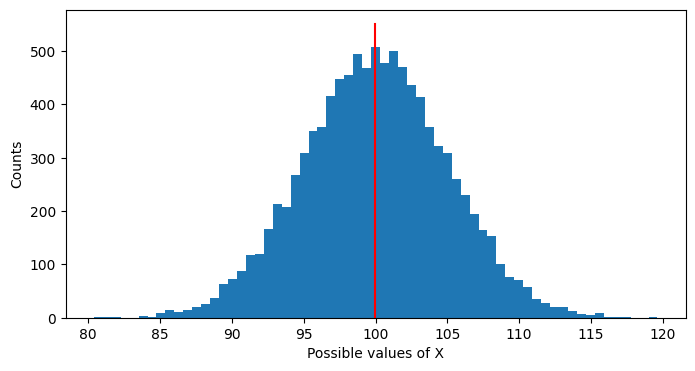

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(X, bins="auto");
ax.plot([X.mean(), X.mean()], [0, 550], 'r-') # Plot the mean
ax.set_xlabel("Possible values of X")
ax.set_ylabel("Counts");

In a (perfect) normal distribution, approximately 68% of all elements of the samples lie within 1 standard deviation above and below the mean; 95% are within 2 standard deviations, and 99.7% are within 3 standard deviations. Let's calculate those boundaries and plot them.

In [8]:
m = X.mean()
s = X.std()
one_std_high = m + s
one_std_low = m - s
two_std_high = m + 2 * s
two_std_low = m - 2 * s
three_std_high = m + 3 * s
three_std_low = m - 3 * s

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(X, bins="auto");
ax.plot([m, m], [0, 550], 'r-') # Plot the mean
ax.plot([one_std_high, one_std_high], [0, 550], 'y-') # Plot one_std_high
ax.plot([one_std_low, one_std_low], [0, 550], 'y-') # Plot one_std_low
ax.plot([two_std_high, two_std_high], [0, 550], 'g-') # Plot two_std_high
ax.plot([two_std_low, two_std_low], [0, 550], 'g-') # Plot two_std_low
ax.plot([three_std_high, three_std_high], [0, 550], 'k-') # Plot three_std_high
ax.plot([three_std_low, three_std_low], [0, 550], 'k-') # Plot three_std_low
ax.set_xlabel("Possible values of X")
ax.set_ylabel("Counts");

Let's also count the elements in the partitions and calculate their fractions.

In [10]:
n_one_std = X[(X >= one_std_low) & (X <= one_std_high)]
f_one_std = len(n_one_std) / len(X) * 100
n_two_std = X[(X >= two_std_low) & (X <= two_std_high)]
f_two_std = len(n_two_std) / len(X) * 100
n_three_std = X[(X >= three_std_low) & (X <= three_std_high)]
f_three_std = len(n_three_std) / len(X) * 100

print(f"{f_one_std:.2f}% are within 1 std; {f_two_std:.2f}% are within 2 std; {f_three_std:.2f}% are within 3 std.")

68.38% are within 1 std; 95.38% are within 2 std; 99.73% are within 3 std.


From the plot above, we see that we can find values above ~115 only around 0.3% of the time in our sample. This concept is at the base of **statistical testing**: given a certain sample of elements (that we assume come from a given **distribution** of objects of the same type), if we see another object that is at a certain distance of the mean of the sample, how likely it is to belong to that same type of objects?

In current example, how likely would it be for a value $x=200$ to belong to the distribution from which we sampled $X$?

## Using sample statistics for thresholding

We can make use of the idea of samples and distributions to try and segment tricky images.

Let's image we have all pixel intensities in the image that belong to the background. If we assume that they belong to the same *class of pixels* (i.e. all background pixels are *generated* by the same process and therefore come from the same distribution), then the intensities from our brighter cells in `S` should not fall into the distribution of the background intensities.

Let's use the inverse of black and white mask of our nuclei to extract the "non-nucleus" part of the image.

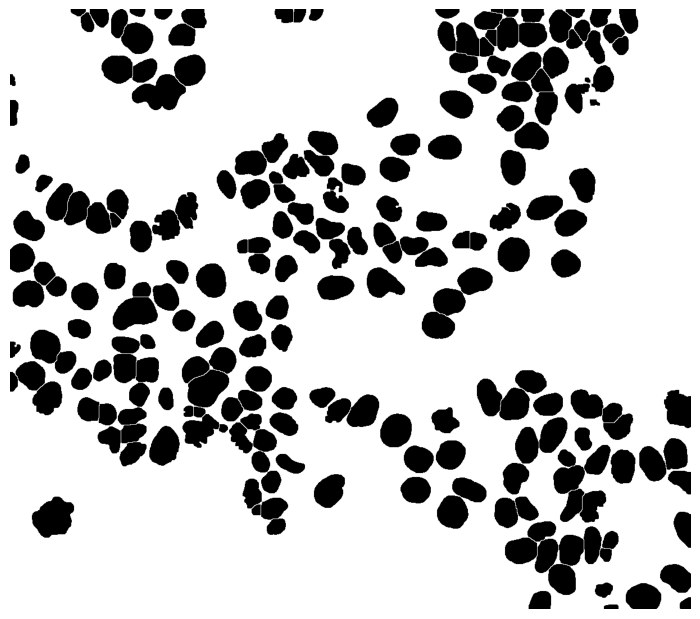

In [11]:
imshow(N == 0)

Let's get the intensities from `S` at the positions where `N==0` is `True` (i.e. for the background pixels).

In [12]:
background = S[N == 0]

Let's get our sample statistics:

In [13]:
m_bkg = background.mean()
s_bkg = background.std()
print(f"The background has mean = {m_bkg:.2f} and std = {s_bkg:.2f}")

The background has mean = 11088.81 and std = 4868.70


Let's now use the assumption that any intensity higher than 3 standard deviations away from the mean is unlikely to belong to the distribution of background pixels, that is, our cells are **outliers** of the population of background pixels.

In [14]:
threshold = m_bkg + 3 * s_bkg
imshow(S > threshold)

This looks already more promising than the attempt with the Otsu algorithm above.

Sometimes, the sample we use to estimate the characteristics of a distribution is not good enough. In our example of the background sample, it may contain some autofluorescent pixels, or some cytoplasmic pixels that do not belong neither to the nuclei that we use to define the backround nor to the actual background, since they fall into the cytoplasm.

In this case, we can use **robust statistics** to work around this issue. Imagine having this sample $Y$:

In [15]:
Y = np.array([1, 2, 1, 0, 2, 1, 0, 1, 0, 1, 1, 2, 1, 15])

It looks likely that the element $15$ does not belong to the rest of the sample. Let's see what is the effect of this **outlier** on our sample statistics. 

In [16]:
print(f"Sample Y has mean = {Y.mean():.2f} and standard deviation = {X.std():.2f}")

Sample Y has mean = 2.00 and standard deviation = 5.02


A robust alternative of the mean is given by the **median**, which is the central value in the sorted sample elements; and a robust alternative for the standard deviation is the **median absolute deviation**. The MAD is usually multiplied by a constant factor $1.4826$ to bring it in the same range as the standard deviation.

In [17]:
md = np.median(Y)
mad = 1.4826 * np.median(np.abs(Y - md))
print(f"Sample Y has median = {md:.2f} and median absolute deviation = {mad:.2f}")

Sample Y has median = 1.00 and median absolute deviation = 0.74


If we use robust statistics on our image, we get the following:

In [18]:
median_bkg = np.median(background)
mad_bkg = 1.4826 * np.median(np.abs(background - median_bkg))
print(f"The background has median = {median_bkg:.2f} and MAD = {mad_bkg:.2f}")

The background has median = 11565.00 and MAD = 5715.42


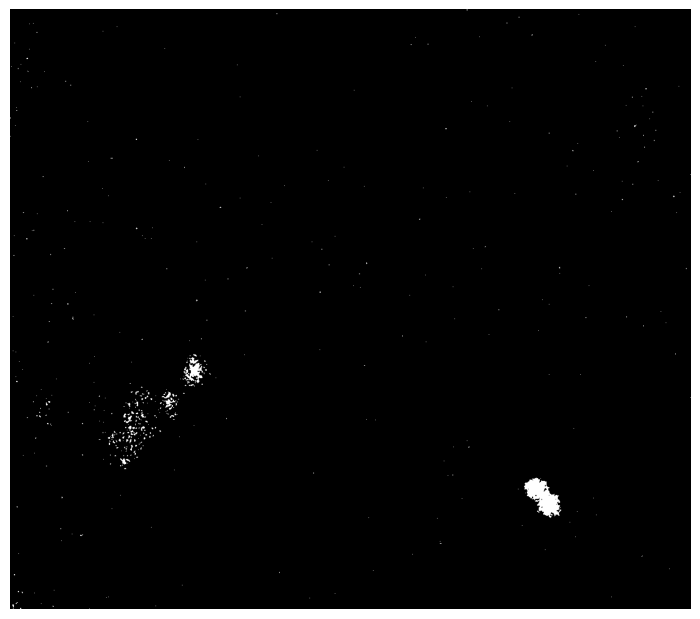

In [19]:
threshold = median_bkg + 3 * mad_bkg
imshow(S > threshold)

**Exercise:** Use the pixels that belong to the nuclei to estimate the signal backround (in the nuclei).